## Dieses Notebook enthält die Schritte der explorativen Datenanalyse und eine erste Untersuchung des initialen Datensatzes

## Codeabschnitt

##### Das Verzeichnis festlegen

In [1]:
import sys
from pathlib import Path

# Zum übergeordneten Ordner 'src' wechseln
current_path = Path().resolve()
src_path = current_path.parents[3]  # Zwei Stufen nach oben

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    
print(f"Achtung, der globale Pfad wurde auf {src_path} gesetzt")

Achtung, der globale Pfad wurde auf C:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24 gesetzt


##### Imports & Downloads

In [2]:


import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
import os
from src.functions.shortcut_lists import shortcuts, shortforms
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from textblob import Word, TextBlob
pd.set_option('display.max_colwidth', None)
from src.functions.clean_data_generic_functions import clean_misspelled_words, correct_misspelled_words_in_sentence,create_word_counter,expand_slang,expand_shortcuts,extract_emojis, to_lowercase, to_lowercase_if_string, handle_hashtags, handle_userhandles, lemmatize, remove_word_from_column, remove_na_from_column, replace_smileys, replace_text_smileys, segment_text_cases, segment_text_english, segment_text_twitter, segment_tweets
from src.functions.clean_data_generic_functions import remove_special_characters, remove_digits, remove_duplicates, remove_emoji_in_sentence, remove_emojis, remove_freqwords,remove_hashtag_sign_from_tweet,remove_least_frequent_words, remove_most_frequent_words, remove_punctuation, remove_stop_words, remove_url_from_tweet, replace_emoji_in_sentence, replace_emojis


from PIL import Image
import os


Reading english - 1grams ...
Reading english - 2grams ...


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...
Reading english - 2grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [14]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Nasiba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nasiba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Beladung der Daten

In [3]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/train.csv'))
df_origin = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)
filepath_name = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/train_cleaned.csv'))
df_cleaned_origin = pd.read_csv(filepath_name, encoding='utf-8')

source_filepath_name_test = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/test.csv'))
df_origin_test = pd.read_csv(source_filepath_name_test, encoding='utf-8', index_col=0)
filepath_name_test = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/test_cleaned.csv'))
df_cleaned_test = pd.read_csv(filepath_name_test, encoding='utf-8', index_col=0)

#### Datenumfang

In [5]:
df_cleaned = df_cleaned_origin.copy()

In [17]:
print("Anzahl Datensätze der unbereinigten Traindaten")
print(df_origin.tweet.count())
print("Anzahl Datensätze der bereinigten Traindaten")
print(df_cleaned.tweet.count())
print("Anzahl der entfernten Datensätze während Cleaning")
print(df_cleaned.tweet.count() - df_origin.tweet.count())
print("Anteil der entfernten Datensätze während Cleaning")
print((df_cleaned.tweet.count() / df_origin.tweet.count() - 1) * 100)

Anzahl Datensätze der unbereinigten Traindaten
22373
Anzahl Datensätze der bereinigten Traindaten
19626
Anzahl der entfernten Datensätze während Cleaning
-2747
Anteil der entfernten Datensätze während Cleaning
-12.278192464130877


In [7]:

print(df_cleaned[df_cleaned['label']== 1].count())
print(df_cleaned[df_cleaned['label'] == 0].count())


id               1331
label            1331
tweet            1331
tweet_cleaned    1331
user_handle      1331
hashtags         1331
emojis             74
dtype: int64
id               18848
label            18848
tweet            18848
tweet_cleaned    18847
user_handle      18848
hashtags         18848
emojis            4231
dtype: int64


In [18]:
print(df_origin[df_origin.label == 1].count())
print(df_cleaned[df_cleaned.label == 1].count())
print(df_cleaned[df_cleaned.label == 1].count() - df_origin[df_origin.label == 1].count())
print((df_cleaned[df_cleaned.label == 1].count() / df_origin[df_origin.label == 1].count() - 1) * 100)

label    1574
tweet    1574
dtype: int64
id               1304
label            1304
tweet            1304
tweet_cleaned    1304
user_handle      1304
hashtags         1304
emojis             66
dtype: int64
emojis             NaN
hashtags           NaN
id                 NaN
label           -270.0
tweet           -270.0
tweet_cleaned      NaN
user_handle        NaN
dtype: float64
emojis                 NaN
hashtags               NaN
id                     NaN
label           -17.153748
tweet           -17.153748
tweet_cleaned          NaN
user_handle            NaN
dtype: float64


#### Label Verteilung bereinigte vs. unbereinigte Datensätze

In [19]:
# Klassenverteilung in den ursprünglichen Trainingsdaten
train_label_counts = df_origin['label'].value_counts()
print("Klassenverteilung in den ursprünglichen Trainingsdaten:")
print(train_label_counts)

# Klassenverteilung in den bereinigten Trainingsdaten
train_cleaned_label_counts = df_cleaned['label'].value_counts()
print("\nKlassenverteilung in den bereinigten Trainingsdaten:")
print(train_cleaned_label_counts)


Klassenverteilung in den ursprünglichen Trainingsdaten:
label
0    20799
1     1574
Name: count, dtype: int64

Klassenverteilung in den bereinigten Trainingsdaten:
label
0    18322
1     1304
Name: count, dtype: int64


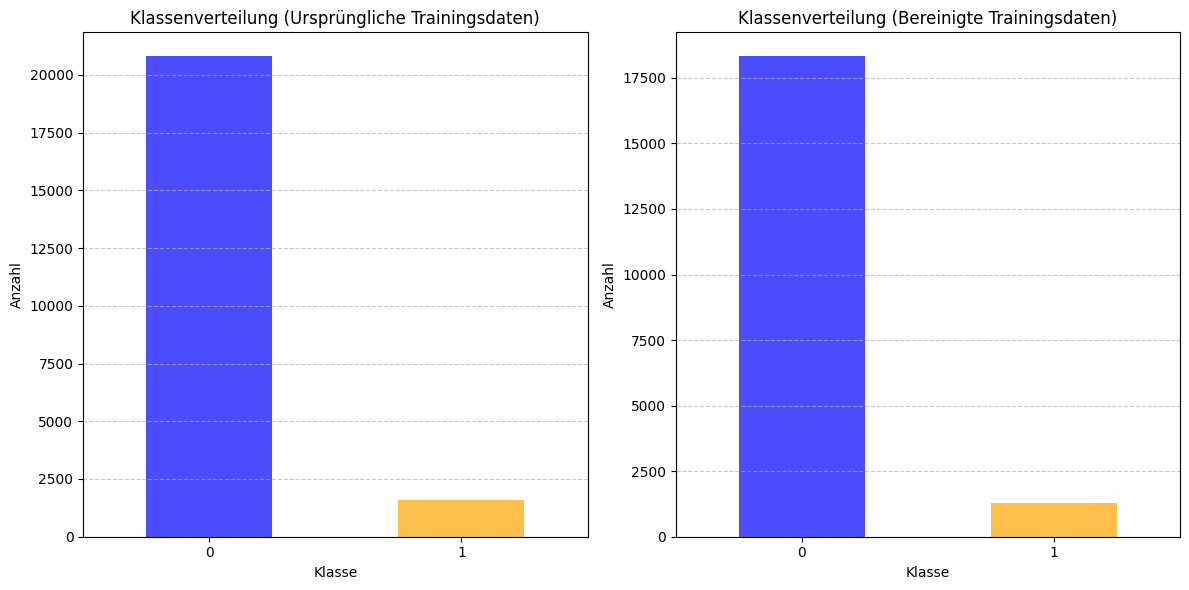

In [20]:
# Visualisierung der Klassenverteilung
plt.figure(figsize=(12, 6))

# Originale Daten
plt.subplot(1, 2, 1)
train_label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title('Klassenverteilung (Ursprüngliche Trainingsdaten)')
plt.xlabel('Klasse')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Bereinigte Daten
plt.subplot(1, 2, 2)
train_cleaned_label_counts.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title('Klassenverteilung (Bereinigte Trainingsdaten)')
plt.xlabel('Klasse')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### Statistiken der Train Daten vs. Test Daten

In [21]:
# Berechnung der Länge der Tweets
train_data_len = df_origin['tweet'].str.len()
test_data_len = df_origin_test['tweet'].str.len()

train_cleaned_data_len = df_cleaned['tweet_cleaned_2'].str.len()
test_cleaned_data_len = df_cleaned_test['tweet_cleaned_2'].str.len()

# Statistiken für Trainingsdaten
print("Statistiken zur Länge der Trainingsdaten:")
print(f"Durchschnittliche Länge: {train_data_len.mean():.2f}")
print(f"Median der Länge: {train_data_len.median():.2f}")
print(f"Minimale Länge: {train_data_len.min()}")
print(f"Maximale Länge: {train_data_len.max()}")
print(f"Standardabweichung: {train_data_len.std():.2f}\n")

# Statistiken für Testdaten
print("Statistiken zur Länge der Testdaten:")
print(f"Durchschnittliche Länge: {test_data_len.mean():.2f}")
print(f"Median der Länge: {test_data_len.median():.2f}")
print(f"Minimale Länge: {test_data_len.min()}")
print(f"Maximale Länge: {test_data_len.max()}")
print(f"Standardabweichung: {test_data_len.std():.2f} \n")

# Statistiken für bereinigte Trainingsdaten
print("Statistiken zur Länge der bereinigten Trainingsdaten:")
print(f"Durchschnittliche Länge: {train_cleaned_data_len.mean():.2f}")
print(f"Median der Länge: {train_cleaned_data_len.median():.2f}")
print(f"Minimale Länge: {train_cleaned_data_len.min()}")
print(f"Maximale Länge: {train_cleaned_data_len.max()}")
print(f"Standardabweichung: {train_cleaned_data_len.std():.2f}\n")

# Statistiken für bereinigte Testdaten
print("Statistiken zur Länge der bereinigten Testdaten:")
print(f"Durchschnittliche Länge: {test_cleaned_data_len.mean():.2f}")
print(f"Median der Länge: {test_cleaned_data_len.median():.2f}")
print(f"Minimale Länge: {test_cleaned_data_len.min()}")
print(f"Maximale Länge: {test_cleaned_data_len.max()}")
print(f"Standardabweichung: {test_cleaned_data_len.std():.2f}\n")


KeyError: 'tweet_cleaned_2'

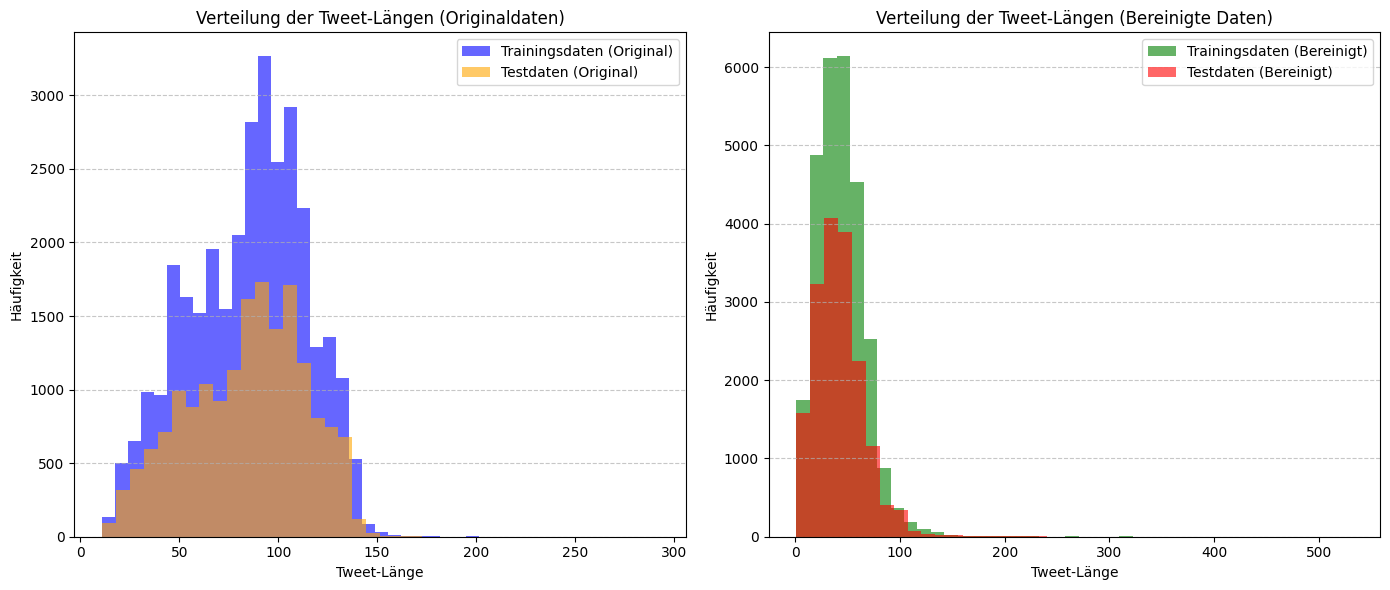

In [ ]:
# Erstellung der Subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Originaldaten
plt.subplot(1, 2, 1)
plt.hist(train_data_len, bins=40, alpha=0.6, label='Trainingsdaten (Original)', color='blue')
plt.hist(test_data_len, bins=40, alpha=0.6, label='Testdaten (Original)', color='orange')
plt.title('Verteilung der Tweet-Längen (Originaldaten)')
plt.xlabel('Tweet-Länge')
plt.ylabel('Häufigkeit')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Bereinigte Daten
plt.subplot(1, 2, 2)
plt.hist(train_cleaned_data_len, bins=40, alpha=0.6, label='Trainingsdaten (Bereinigt)', color='green')
plt.hist(test_cleaned_data_len, bins=40, alpha=0.6, label='Testdaten (Bereinigt)', color='red')
plt.title('Verteilung der Tweet-Längen (Bereinigte Daten)')
plt.xlabel('Tweet-Länge')
plt.ylabel('Häufigkeit')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Layout-Anpassung und Anzeige
plt.tight_layout()
plt.show()


#### Analyse der Wörter in Tweets

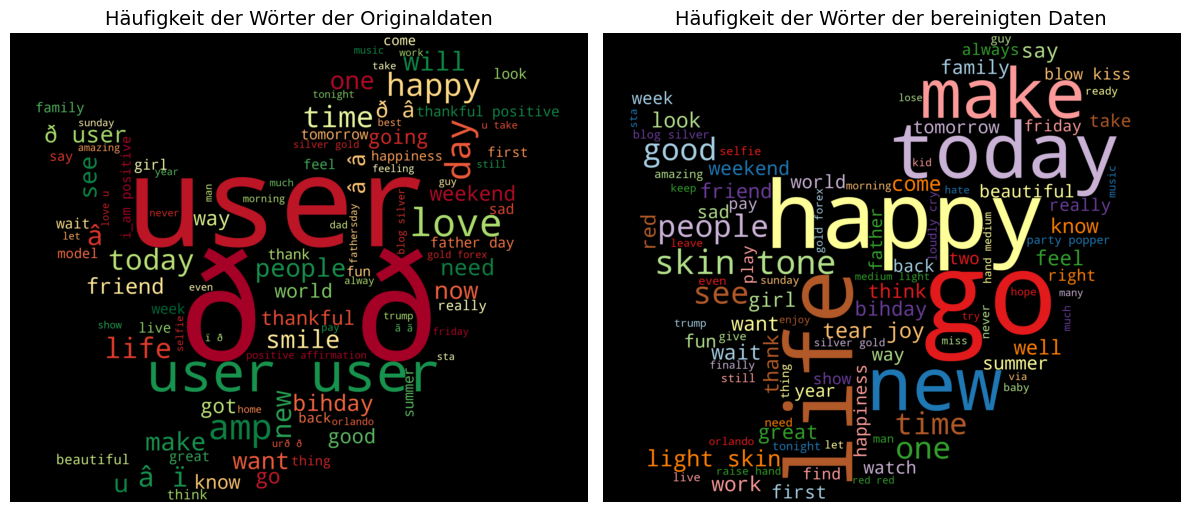

In [ ]:
from PIL import Image
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_mask = np.array(Image.open("twitter.png"))

df_origin['tweet'] = df_origin['tweet'].apply(lambda x: x if isinstance(x, str) else '')
#origin_text = " ".join(tweet for tweet in df_origin['tweet'])

# Verarbeitung der Daten aus df_cleaned
df_cleaned['tweet_cleaned_2'] = df_cleaned['tweet_cleaned_2'].apply(lambda x: x if isinstance(x, str) else '')
#cleaned_text = " ".join(tweet for tweet in df_cleaned['tweet_cleaned_2'])

dataset_1_text = " ".join(df_origin["tweet"].tolist())  
dataset_2_text = " ".join(df_cleaned["tweet_cleaned"].tolist())  

plt.figure(figsize=(12, 6)) 

# Subplot 1: Dataset 1
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='RdYlGn').generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Häufigkeit der Wörter der Originaldaten", fontsize=14)  

# Subplot 2: Dataset 2
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='Paired').generate(dataset_2_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Häufigkeit der Wörter der bereinigten Daten", fontsize=14)  


plt.tight_layout()
plt.show()


#### Analyse der Wörter in Hate Speech Tweets

C:\Users\Nasiba\AppData\Local\Temp\ipykernel_23052\563957184.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_origin_label_1['tweet'] = df_origin_label_1['tweet'].apply(lambda x: x if isinstance(x, str) else '')
C:\Users\Nasiba\AppData\Local\Temp\ipykernel_23052\563957184.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_1['tweet_cleaned'] = df_cleaned_label_1['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')


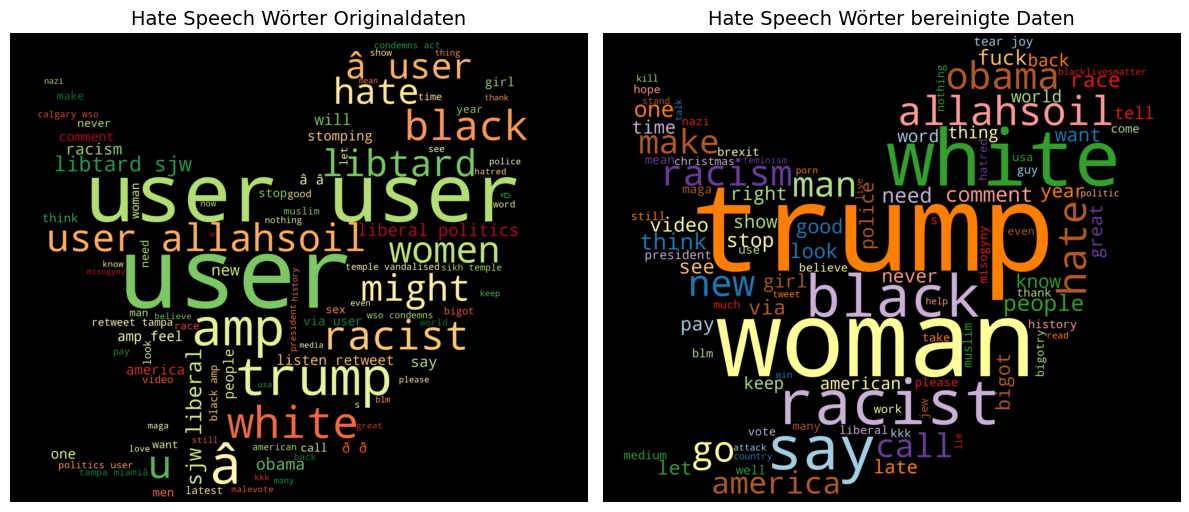

In [ ]:
wordcloud_mask = np.array(Image.open("twitter.png"))

df_origin_label_1= df_origin[df_origin['label']==1]
df_cleaned_label_1= df_cleaned[df_cleaned['label']==1]


df_origin_label_1['tweet'] = df_origin_label_1['tweet'].apply(lambda x: x if isinstance(x, str) else '')

df_cleaned_label_1['tweet_cleaned_2'] = df_cleaned_label_1['tweet_cleaned_2'].apply(lambda x: x if isinstance(x, str) else '')

dataset_1_text = " ".join(df_origin_label_1["tweet"].tolist())  
dataset_2_text = " ".join(df_cleaned_label_1["tweet_cleaned"].tolist())  

plt.figure(figsize=(12, 6)) 

# Subplot 1: Dataset 1
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='RdYlGn').generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Hate Speech Wörter Originaldaten", fontsize=14)  

# Subplot 2: Dataset 2
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='Paired').generate(dataset_2_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Hate Speech Wörter bereinigte Daten", fontsize=14)  


plt.tight_layout()
plt.show()


#### Vergleich No Hate Speech/ Hate Speech

C:\Users\Nasiba\AppData\Local\Temp\ipykernel_23052\3698619367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_0['tweet_cleaned'] = df_cleaned_label_0['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')
C:\Users\Nasiba\AppData\Local\Temp\ipykernel_23052\3698619367.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_1['tweet_cleaned'] = df_cleaned_label_1['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')


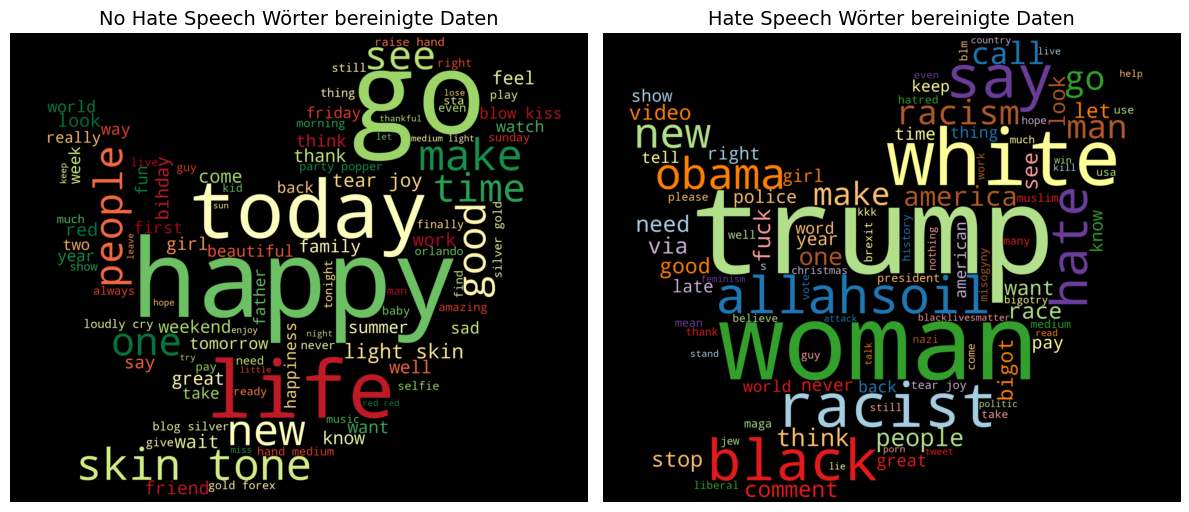

In [ ]:
wordcloud_mask = np.array(Image.open("twitter.png"))

df_cleaned_label_0= df_cleaned[df_cleaned['label']==0]
df_cleaned_label_1= df_cleaned[df_cleaned['label']==1]


df_cleaned_label_0['tweet_cleaned'] = df_cleaned_label_0['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')

df_cleaned_label_1['tweet_cleaned'] = df_cleaned_label_1['tweet_cleaned'].apply(lambda x: x if isinstance(x, str) else '')

dataset_1_text = " ".join(df_cleaned_label_0['tweet_cleaned'].tolist())  
dataset_2_text = " ".join(df_cleaned_label_1["tweet_cleaned"].tolist())  

plt.figure(figsize=(12, 6)) 

# Subplot 1: Dataset 1
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='RdYlGn').generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("No Hate Speech Wörter bereinigte Daten", fontsize=14)  

# Subplot 2: Dataset 2
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='Paired').generate(dataset_2_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Hate Speech Wörter bereinigte Daten", fontsize=14)  


plt.tight_layout()
plt.show()


#### Hashtag Analyse

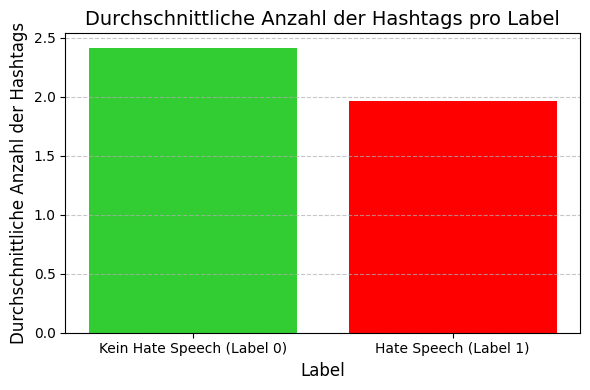

Durchschnittliche Anzahl der Hashtags in 'Kein Hate Speech' Tweets: 2.42
Durchschnittliche Anzahl der Hashtags in 'Hate Speech' Tweets: 1.96


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Gruppieren der Daten basierend auf dem Label und Berechnung der durchschnittlichen Anzahl der Hashtags

df_cleaned_new = df_cleaned.copy()
df_cleaned_new['num_hashtags'] = df_cleaned_new['hashtags'].apply(lambda x: len(eval(x)) if isinstance(x, str) and x.startswith('[') else 0)

avg_hashtags = df_cleaned_new.groupby('label')['num_hashtags'].mean()

# Erstellen eines Barplots
plt.figure(figsize=(6, 4))
plt.bar(['Kein Hate Speech (Label 0)', 'Hate Speech (Label 1)'], avg_hashtags, color=['limegreen', 'red'])
plt.title('Durchschnittliche Anzahl der Hashtags pro Label', fontsize=14)
plt.ylabel('Durchschnittliche Anzahl der Hashtags', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Anzeige des Ergebnisses
plt.tight_layout()
plt.show()

# Ausgabe der genauen Werte zur Unterstützung der Analyse
print(f"Durchschnittliche Anzahl der Hashtags in 'Kein Hate Speech' Tweets: {avg_hashtags[0]:.2f}")
print(f"Durchschnittliche Anzahl der Hashtags in 'Hate Speech' Tweets: {avg_hashtags[1]:.2f}")


C:\Users\Nasiba\AppData\Local\Temp\ipykernel_23052\3782159774.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_0['hashtags'] = df_cleaned_label_0['hashtags'].apply(lambda x: x if isinstance(x, str) else '')
C:\Users\Nasiba\AppData\Local\Temp\ipykernel_23052\3782159774.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_1['hashtags'] = df_cleaned_label_1['hashtags'].apply(lambda x: x if isinstance(x, str) else '')


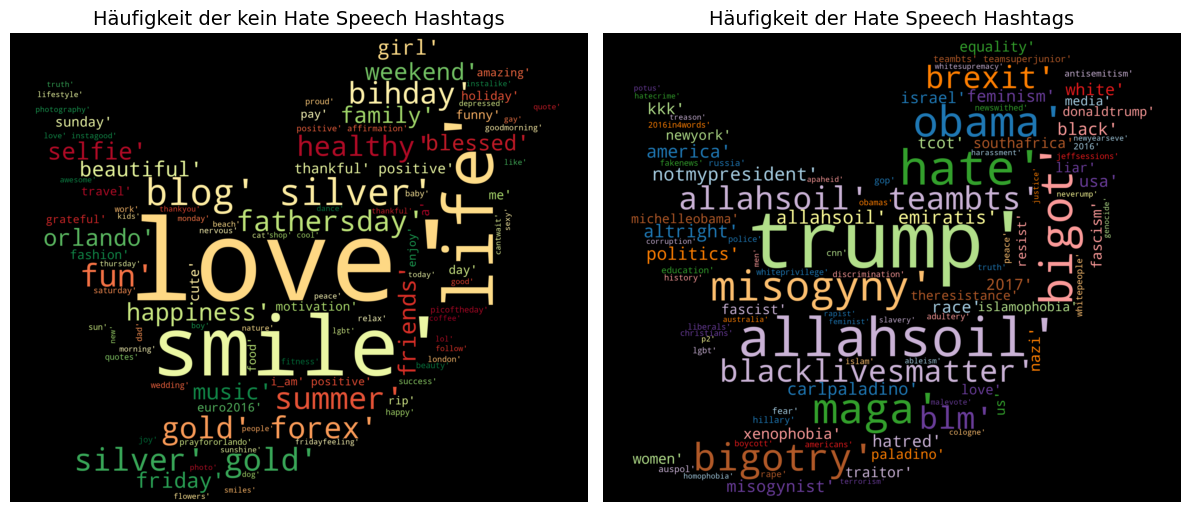

In [ ]:
wordcloud_mask = np.array(Image.open("twitter.png"))

df_cleaned_label_0= df_cleaned[df_cleaned['label']==0]
df_cleaned_label_1= df_cleaned[df_cleaned['label']==1]


df_cleaned_label_0['hashtags'] = df_cleaned_label_0['hashtags'].apply(lambda x: x if isinstance(x, str) else '')

df_cleaned_label_1['hashtags'] = df_cleaned_label_1['hashtags'].apply(lambda x: x if isinstance(x, str) else '')

dataset_1_text = " ".join(df_cleaned_label_0["hashtags"].tolist())  
dataset_2_text = " ".join(df_cleaned_label_1["hashtags"].tolist())  

plt.figure(figsize=(12, 6)) 

# Subplot 1: Dataset 1
plt.subplot(1, 2, 1)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='RdYlGn').generate(dataset_1_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Häufigkeit der kein Hate Speech Hashtags", fontsize=14)  

# Subplot 2: Dataset 2
plt.subplot(1, 2, 2)
wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, mask=wordcloud_mask, colormap='Paired').generate(dataset_2_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Häufigkeit der Hate Speech Hashtags", fontsize=14)  


plt.tight_layout()
plt.show()


#### Anzahl von Mentions und Hashtags pro Tweet

In [ ]:

df_cleaned_new['num_mentions'] = df_cleaned_new['tweet'].apply(lambda x: x.count('@'))
df_cleaned_new['num_hashtags'] = df_cleaned_new['tweet'].apply(lambda x: x.count('#'))

df_cleaned_new['num_mentions'] = df_cleaned_new['tweet'].apply(lambda x: x.count('@'))
df_cleaned_new['num_hashtags'] = df_cleaned_new['tweet'].apply(lambda x: x.count('#'))

mentions_stats = {
    "Mean Mentions": df_cleaned_new['num_mentions'].mean(),
    "Median Mentions": df_cleaned_new['num_mentions'].median(),
    "Max Mentions": df_cleaned_new['num_mentions'].max(),
    "Min Mentions": df_cleaned_new['num_mentions'].min(),
    "Total Mentions": df_cleaned_new['num_mentions'].sum()
}

hashtags_stats = {
    "Mean Hashtags": df_cleaned_new['num_hashtags'].mean(),
    "Median Hashtags": df_cleaned_new['num_hashtags'].median(),
    "Max Hashtags": df_cleaned_new['num_hashtags'].max(),
    "Min Hashtags": df_cleaned_new['num_hashtags'].min(),
    "Total Hashtags": df_cleaned_new['num_hashtags'].sum()
}

print("Statistics for Mentions (@):")
for key, value in mentions_stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

print("\nStatistics for Hashtags (#):")
for key, value in hashtags_stats.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")


Statistics for Mentions (@):
Mean Mentions: 0.59
Median Mentions: 0.00
Max Mentions: 10
Min Mentions: 0
Total Mentions: 16248

Statistics for Hashtags (#):
Mean Hashtags: 2.40
Median Hashtags: 2.00
Max Hashtags: 20
Min Hashtags: 0
Total Hashtags: 66356


C:\Users\Nasiba\AppData\Local\Temp\ipykernel_23052\322232222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_label_1['num_mentions'] = df_cleaned_label_1['tweet'].apply(lambda x: x.count('@'))


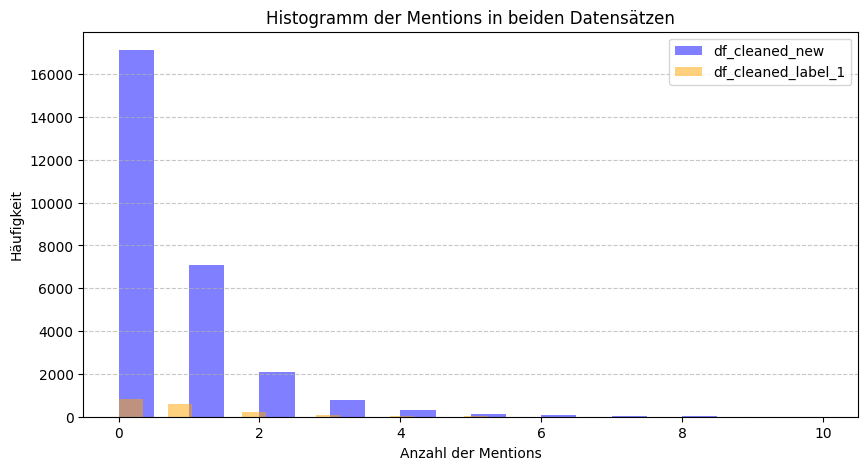

In [ ]:

df_cleaned_new['num_mentions'] = df_cleaned_new['tweet'].apply(lambda x: x.count('@'))
df_cleaned_label_1['num_mentions'] = df_cleaned_label_1['tweet'].apply(lambda x: x.count('@'))


plt.figure(figsize=(10, 5))

# Histogramm für df_cleaned_new
plt.hist(df_cleaned_new['num_mentions'], bins=20, alpha=0.5, label='df_cleaned_new', color='blue')

# Histogramm für df_cleaned_label_1
plt.hist(df_cleaned_label_1['num_mentions'], bins=20, alpha=0.5, label='df_cleaned_label_1', color='orange')

plt.xlabel("Anzahl der Mentions")
plt.ylabel("Häufigkeit")
plt.title("Histogramm der Mentions in beiden Datensätzen")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [ ]:

df_cleaned_emojis = df_cleaned[df_cleaned['emojis'].notna()]
df_cleaned_emojis_label_1 = df_cleaned_label_1[df_cleaned_label_1['emojis'].notna()]

anzahl_datensätze_gesamt = df_cleaned['id'].count()
anzahl_datensätze_mit_emojis = df_cleaned_emojis['id'].count()

anzahl_datensätze_label1 = df_cleaned_label_1['id'].count()
anzahl_datensätze_mit_emojis_label1 = df_cleaned_emojis_label_1['id'].count()

print("Datensätze gesamt/mit emoji")
print(anzahl_datensätze_gesamt)
print(anzahl_datensätze_mit_emojis)

print("Datensätze label1/mit emoji")
print(anzahl_datensätze_label1)
print(anzahl_datensätze_mit_emojis_label1)



Datensätze gesamt/mit emoji
27611
5906
Datensätze label1/mit emoji
1805
92


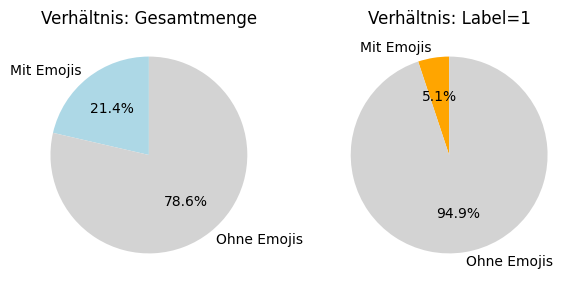

In [ ]:
# Daten für die Kreisdiagramme
# 1. Kreisdiagramm: Verhältnis für alle Datensätze
data_gesamt = [anzahl_datensätze_mit_emojis, anzahl_datensätze_gesamt - anzahl_datensätze_mit_emojis]
labels_gesamt = ['Mit Emojis', 'Ohne Emojis']

# 2. Kreisdiagramm: Verhältnis für Datensätze mit label=1
data_label1 = [anzahl_datensätze_mit_emojis_label1, anzahl_datensätze_label1 - anzahl_datensätze_mit_emojis_label1]
labels_label1 = ['Mit Emojis', 'Ohne Emojis']

# Erstellung der Subplots für zwei Kreisdiagramme
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Kreisdiagramm 1: Alle Datensätze
axes[0].pie(data_gesamt, labels=labels_gesamt, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgrey'])
axes[0].set_title('Verhältnis: Gesamtmenge')

# Kreisdiagramm 2: Datensätze mit label=1
axes[1].pie(data_label1, labels=labels_label1, autopct='%1.1f%%', startangle=90, colors=['orange', 'lightgrey'])
axes[1].set_title('Verhältnis: Label=1')

# Layout-Anpassung und Anzeige
plt.tight_layout()
plt.show()

In [ ]:
df_cleaned[['tweet','tweet_cleaned']].head(50)

,tweet,tweet_cleaned
0,@user #cinemaaawards final rehearsals!! gearing up for the evening!! #butterflies #stage ! hope u all like it,final rehearsal gear evening butterfly stage hope like
1,istg this is the best cheese ta but dayum expensive,good cheese ta expensive
2,this was amazing. the weather was not. #musical #london #matilda #westend #weekend …,amazing weather musical london weekend
3,yes! #talented #sexy ‘criminal minds’ casts @user as series regular for season 12 via @user,yes talented sexy ' criminal mind ' cast series regular season via
4,want to be while being #successful? see how #worklifebalance helps in by @user @user,want successful see help
5,"really, @user !!!!! #thepurge is what you show on #fathersday for a movie trailer? kids are watching! get a clue!!!",really show fathersday movie trailer kid watch get clue
6,be happy. be bright. be you.💖👑 #monday #motivation #inspiration,happy bright sparkle crown monday motivation inspiration
7,where is the world heading? you could lose your life just for leaving your home. #orlando,world head could lose life leave home orlando
8,#horsepower bull up: you will dominate your bull and you will direct it whatever you want it to do. when y,bull dominate bull direct whatever want
9,#bihday! a new #porait of #princenicolas of #sweden who turns 1 today. #congrats! #kongebloggen #royals,bihday new porait sweden turn today congrats royal


#### Data Qualitiy Checks nach Data Cleaning

In [4]:
df_cleaned = df_cleaned_origin.copy()

In [5]:
df_cleaned['tweet_cleaned_2'] = df_cleaned['tweet']
df_cleaned = to_lowercase(df_cleaned,'tweet_cleaned_2')


In [6]:
df_cleaned = replace_text_smileys(df_cleaned,'tweet_cleaned_2')

In [7]:
df_cleaned = expand_shortcuts(df_cleaned,'tweet_cleaned_2')

In [8]:
df_cleaned = handle_userhandles(df_cleaned,'tweet_cleaned_2')

In [9]:
df_cleaned = handle_hashtags(df_cleaned,'tweet_cleaned_2')

In [10]:
df_cleaned = extract_emojis(df_cleaned,'tweet_cleaned_2')

In [11]:
df_cleaned = replace_emojis(df_cleaned,'tweet_cleaned_2')

In [12]:
df_cleaned = remove_url_from_tweet(df_cleaned,'tweet_cleaned_2')

In [13]:
df_cleaned = remove_punctuation(df_cleaned,'tweet_cleaned_2')

In [14]:
df_cleaned = remove_special_characters(df_cleaned, 'tweet_cleaned_2')

In [15]:
df_cleaned = remove_digits(df_cleaned,'tweet_cleaned_2')

In [16]:
df_cleaned = remove_word_from_column(df=df_cleaned, column_name="tweet_cleaned",word="amp")

In [17]:
df_cleaned = lemmatize(df_cleaned,'tweet_cleaned_2')

In [18]:
df_cleaned = remove_stop_words(df_cleaned,'tweet_cleaned_2')

In [19]:
df_cleaned = remove_duplicates(df_cleaned,'tweet_cleaned_2')

In [20]:
df_cleaned=remove_na_from_column(df=df_cleaned, column_name="tweet_cleaned")

In [108]:
df_cleaned = remove_least_frequent_words(df_cleaned,'tweet_cleaned_2')

In [ ]:
df_cleaned = remove_most_frequent_words(df_cleaned,'tweet_cleaned_2')

In [21]:
from ekphrasis.classes.segmenter import Segmenter

# Initialisiere Segmenter nur einmal
seg_cases = Segmenter()  # Für CamelCase
seg_english = Segmenter(corpus="english")  # Für englischen Text
seg_twitter = Segmenter(corpus="twitter")  # Für Twitter-Daten
def segment_text_cases(text, segmenter):
    """
    Separates CamelCase and pascalCase words into strings.
    """
    new_text = []
    for w in text.split():
        new_word = segmenter.segment(w)
        new_text.append(new_word)
    return ' '.join(new_text)

def segment_text_english(text, segmenter):
    """
    Separates English words into strings using a provided corpus.
    """
    new_text = []
    for w in text.split():
        new_word = segmenter.segment(w)
        new_text.append(new_word)
    return ' '.join(new_text)

def segment_text_twitter(text, segmenter):
    """
    Separates Twitter-specific words into strings using a Twitter corpus.
    """
    new_text = []
    for w in text.split():
        new_word = segmenter.segment(w)
        new_text.append(new_word)
    return ' '.join(new_text)

def segment_tweets(df, column_name):
    """
    Segments all text in the specified column of a DataFrame using preloaded Segmenters.
    """
    # Kombiniere die Segmentierungen in einer einzigen Iteration
    def combined_segmentation(text):
        text = segment_text_cases(text, seg_cases)
        text = segment_text_english(text, seg_english)
        text = segment_text_twitter(text, seg_twitter)
        return text

    df[column_name] = df[column_name].fillna('').apply(combined_segmentation)
    return df



Reading english - 1grams ...
Reading english - 2grams ...


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...
Reading english - 2grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [22]:
df_cleaned = segment_tweets(df_cleaned,'tweet_cleaned_2')

In [8]:
df_cleaned.head(1)

,id,label,tweet,tweet_cleaned,user_handle,hashtags,emojis,tweet_cleaned_2
0,8886,0,@user #cinemaaawards final rehearsals!! gearing up for the evening!! #butterflies #stage ! hope u all like it,final rehearsal gear evening butterfly stage hope like,1,"['#cinemaaawards', '#butterflies', '#stage']",NaN,@user #cinemaaawards final rehearsals!! gearing up for the evening!! #butterflies #stage ! hope u all like it


In [18]:
df_cleaned_check = df_cleaned[df_cleaned['label']==1]


df_cleaned_check.sort_values(by='id', ascending=True).head(50)

 


,id,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
13665,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot,cnn call michigan middle school build wall chant tc ot,1,"['#cnn', '#michigan', '#tcot']",NaN
16780,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins,comment australia op kill bay sea shepherd help cove dolphin cove help cove dolphin,0,"['#australia', '#opkillingbay', '#seashepherd', '#helpcovedolphins', '#thecove', '#helpcovedolphins']",NaN
16480,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia,unbelievable st century need something like never ump xenophobia,0,"['#neverump', '#xenophobia']",NaN
2013,69,1,😩the white establishment can't have blk folx running around loving themselves and promoting our greatness,weary face white establishment blk folx run around love promote greatness,0,[],__weary_face__
19589,78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #med…",hey white people call people white race identity …,2,"['#race', '#identity', '#med']",NaN
18305,112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics brings…,interested linguistics address race racism power r cio linguistic bring …,1,"['#linguistics', '#race', '#power', '#raciolinguistics']",NaN
13241,115,1,@user why not @user mocked obama for being black. @user @user @user @user #brexit,mock obama black br exit,6,['#brexit'],NaN
8634,157,1,"as the smaller hands show, barry probably lied about being why his #knicks game sucked more than his #golf…",small hand show barry probably lie knick game suck golf …,0,"['#knicks', '#golf']",NaN
937,168,1,"@user @user you point one finger @user millions are pointed right back at you, #jewishsupremacist",point one finger million point right back jewish supremacist,3,['#jewishsupremacist'],NaN
93,233,1,"if you hold open a door for a woman because she's a woman and not because it's a nice thing to do, that's . don't even try to deny it",hold open door woman woman nice thing even try deny,0,[],NaN


#### Überprüfung der Datenqualität: Die Tweets mit uplausibeln Labels:

In [35]:
df_cleaned[df_cleaned['id'].isin([6640,1208,1156,1117,812])]


,id,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
271,6640,1,and #misogyny is alive and well on the #left. never let them tell you it isn't.,misogyny alive well left never let tell,0,"['#misogyny', '#left']",NaN
1736,812,1,"i guess @user is talking about progress in the advancement of , #misogyny, #homophobia, #bigotry",guess talk progress advancement misogyny homophobia bigotry,1,"['#misogyny', '#homophobia', '#bigotry']",NaN
3388,1117,1,no 'racist intent'? is this guy joking? via @user #trump #barackobama #michelleobama,racist intent guy joke via trump barack obama michelle obama,1,"['#trump', '#barackobama', '#michelleobama']",NaN
11140,1208,1,the latest the maryland daily! thanks to @user @user #chrismukkah,late maryland daily thank chrismukkah,2,['#chrismukkah'],NaN
17635,1156,1,@user i would have never guessed i would be so disappointed in a city. #berlin,would never guess would disappointed city berlin,1,['#berlin'],NaN


In [19]:
df_cleaned_check[df_cleaned_check['tweet'].str.contains("misogyny")]


,id,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
271,6640,1,and #misogyny is alive and well on the #left. never let them tell you it isn't.,misogyny alive well left never let tell,0,"['#misogyny', '#left']",NaN
1736,812,1,"i guess @user is talking about progress in the advancement of , #misogyny, #homophobia, #bigotry",guess talk progress advancement misogyny homophobia bigotry,1,"['#misogyny', '#homophobia', '#bigotry']",NaN
2216,10167,1,motherhood...unscripted new post: happy new year – seriously. #2016 #celebritydeath #trump #misogyny #hate,motherhood unscripted new post happy new year – seriously celebrity death trump misogyny hate,0,"['#2016', '#celebritydeath', '#trump', '#misogyny', '#hate']",NaN
2416,6337,1,makes me sick that 4 ovr 25 yrs idolized george bailey but 2016 #uspoli choose #potter / #greed / #lies #misogyny/ learned 0 #fail,make sick ovr yrs idolize george bailey us poli choose potter greed lie misogyny learn fail,0,"['#uspoli', '#potter', '#greed', '#lies', '#misogyny', '#fail']",NaN
2650,10798,1,@user is #trump what the lds church stands for? who knew? #adultery #misogyny #bigotry #incest #pedophilia #ra…,trump lds church stand know adultery misogyny bigotry incest pedophilia ra …,1,"['#trump', '#adultery', '#misogyny', '#bigotry', '#incest', '#pedophilia', '#ra']",NaN
2740,23678,1,"@user by the time you get to saying #notallmen, you've already missed the point. #misogyny #…",time get say man already miss point misogyny …,1,"['#notallmen', '#misogyny']",NaN
2756,13818,1,is #trump what the lds church stands for? who knew? #adultery #misogyny #bigotry #incest #pedophilia #rape @user,trump lds church stand know adultery misogyny bigotry incest pedophilia rape,1,"['#trump', '#adultery', '#misogyny', '#bigotry', '#incest', '#pedophilia', '#rape']",NaN
4004,2969,1,@user why is 4 whores on ring of fire ? #misogyny,whore ring fire misogyny,1,['#misogyny'],NaN
4502,13928,1,"@user back to open , #misogyny, #bigotry, #childlabor",back open misogyny bigotry child labor,1,"['#misogyny', '#bigotry', '#childlabor']",NaN
5391,23082,1,@user @user tremendous oppounity to move our country back 75 years into ove #misogyny and tax breaks for corps.,tremendous oppo unity move country back year ove misogyny tax break corps,2,['#misogyny'],NaN


In [39]:
df_cleaned.head(1)

,id,label,tweet,tweet_cleaned,user_handle,hashtags,emojis,tweet_cleaned_2
0,8886,0,@user #cinemaaawards final rehearsals!! gearing up for the evening!! #butterflies #stage ! hope u all like it,final rehearsal gear evening butterfly stage hope like,1,"[#cinemaaawards, #butterflies, #stage]",,cinemaaaward final rehearsal gear evening butterfly stage hope like


#### Finde nicht plausible Hate Speechs

In [9]:
pd.set_option("display.max_rows", 999)

In [22]:
source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/train.csv'))
df_origin = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)
df_label_1= df_origin[df_origin['label']==1]
df_sorted = df_label_1.reset_index().sort_index()


In [26]:
df_invalid_labels = df_sorted[df_sorted['id'].isin([3937,35,1117,1587,2607])]
df_invalid_labels                                   

,id,label,tweet
175,1587,1,"if talking about makes racism worst, with that logic talking about how talking about racism makes it worst, makes it worst."
287,1117,1,no 'racist intent'? is this guy joking? via @user #trump #barackobama #michelleobama
877,3937,1,the latest science u can use daily! thanks to @user
1283,2607,1,@user most problems can be solved by talking to each other instead of about each other. #politics #relationships #newâ¦
1297,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


In [18]:
df_sorted.head(200)

,label,tweet
id,,
14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia
69,1,ð©the white establishment can't have blk folx running around loving themselves and promoting our greatness
78,1,"@user hey, white people: you can call people 'white' by @user #race #identity #medâ¦"
83,1,how the #altright uses &amp; insecurity to lure men into #whitesupremacy
112,1,@user i'm not interested in a #linguistics that doesn't address #race &amp; . racism is about #power. #raciolinguistics bringsâ¦
115,1,@user why not @user mocked obama for being black. @user @user @user @user #brexit
132,1,#people aren't protesting #trump because a #republican won-they do so because trump has fuhered &amp;â¦


In [20]:
df_sorted.tail(200)

,label,tweet
id,,
27876,1,"'the #mummersparade, by its very dna, is a largely-unrepentant affair that has no business existing'"
27901,1,you might be a libtard if... #libtard #sjw #liberal #politics
27903,1,hot off the press! the nikita news is out! #bestoftheweek
27987,1,@user #feminismiscancer #feminismisterrorism #feminismmuktbharat why #malevote is ignored @user
27990,1,mother daughter blowjob white girl has sex with black guy
28051,1,"@user @user @user @user @user btw, #gandhi was a . in #india, @user adores him (withoâ¦"
28093,1,anothr #bloated #jerodtwin #colluder #angrygaymafia #koolaid #guzzling #hasbeen #failure #flushedð½â¦
28112,1,@user #allahsoil this simplistic worldview exists today in the 10 second soundbite. . â¦ #emiratisâ¦
28143,1,"@user @user liz treacy, @user condone ex-councillor mark hackett's #islamophobia for me @user"


In [ ]:

src_path
source_filepath_name_new_1 = os.path.abspath(os.path.join(src_path, 'src/1. Explorative Analysis & Preprocessing/nasiba/data/hateXplain.csv'))
source_filepath_name_new_1
df_origin_new_1= pd.read_csv(source_filepath_name_new_1, encoding='utf-8')
df_origin_new_1 = df_origin_new_1[df_origin_new_1['post_id'].str.contains("twitter")]
df_origin_new_1[df_origin_new_1['label']=="hatespeech"]

# gesamt: 60444
# hate_speech: 18070
# hate_speech_twitter: 2660


,post_id,annotator_id,label,target,post_tokens
8,1178793830532956161_twitter,3,hatespeech,African,nawt yall niggers ignoring me
9,1179088797964763136_twitter,1,hatespeech,Asian,<user> i am bit confused coz chinese ppl can not access twitter thn how this ching chong using it i think he pakistani 🤔 🤔 🤔
11,1179088797964763136_twitter,3,hatespeech,Asian,<user> i am bit confused coz chinese ppl can not access twitter thn how this ching chong using it i think he pakistani 🤔 🤔 🤔
12,1179085312976445440_twitter,4,hatespeech,"Caucasian, Women",this bitch in whataburger eating a burger with no top bun and holding it palm up i hate white bitches
13,1179085312976445440_twitter,2,hatespeech,"Women, Caucasian",this bitch in whataburger eating a burger with no top bun and holding it palm up i hate white bitches
...,...,...,...,...,...
42274,1278613802464931841_twitter,209,hatespeech,NaN,<user> i hate you
58144,593941188077584385_twitter,221,hatespeech,"Homosexual, African, Hispanic, Jewish, Women",the redskins is trending is there us teams also called the niggers spics kikes bitches or faggots asking for a friend
58145,593941188077584385_twitter,204,hatespeech,"Homosexual, African, Hispanic, Jewish, Women",the redskins is trending is there us teams also called the niggers spics kikes bitches or faggots asking for a friend
59170,804437519194529792_twitter,235,hatespeech,NaN,did i just hear you call that gay try again using words like stupid dumb lame or retarded thanks ☺ ️ 😘


In [44]:
filepath_name = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/train_cleaned.csv'))
new_df=pd.read_csv(filepath_name, encoding='utf-8')
new_df

,id,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
0,8886,0,@user #cinemaaawards final rehearsals!! gearing up for the evening!! #butterflies #stage ! hope u all like it,cinema award final rehearsal gear evening butterfly stage hope like,1,"['#cinemaaawards', '#butterflies', '#stage']",NaN
1,909,0,istg this is the best cheese ta but dayum expensive,tg good cheese day um expensive,0,[],NaN
2,27613,0,this was amazing. the weather was not. #musical #london #matilda #westend #weekend …,amazing weather musical london matilda west end weekend …,0,"['#musical', '#london', '#matilda', '#westend', '#weekend']",NaN
3,15999,0,yes! #talented #sexy ‘criminal minds’ casts @user as series regular for season 12 via @user,yes talented sexy ' criminal mind ' cast series regular season via,2,"['#talented', '#sexy']",NaN
4,23817,0,want to be while being #successful? see how #worklifebalance helps in by @user @user,want successful see work life balance help,2,"['#successful', '#worklifebalance']",NaN
...,...,...,...,...,...,...,...
20174,16407,0,joshwin is always like this! 😂😂 what's wrong with that guy???,josh win always like face tear joy tear joy wrong guy,0,[],"__face_with_tears_of_joy__,__face_with_tears_of_joy__"
20175,6526,0,#makaveli #day i hit 1000 plays with this one hear even my thugged out lil cuz #kingtutkafafi b bumpin...,makaveli day hit play one hear even thugge lil cuz king tut kafa fi b bumpin,0,"['#makaveli', '#day', '#kingtutkafafi']",NaN
20176,8002,1,video men and women malayalees xxx picturebangladeshi,video man woman malaya lee xxx picture bangladeshi,0,[],NaN
20177,323,0,hahaha.. this is me last #friday &amp; #weird,hahaha last friday weird,0,"['#friday', '#weird']",NaN


In [ ]:

src_path
source_filepath_name_new = os.path.abspath(os.path.join(src_path, 'src/1. Explorative Analysis & Preprocessing/nasiba/data/final_hateXplain.csv'))
source_filepath_name_new
df_origin_new= pd.read_csv(source_filepath_name_new, encoding='utf-8', index_col=0)
df_origin_new[df_origin_new['label']=="hatespeech"]

# gesamt: 
# hate_speech: 6484


,label,Race,Religion,Gender,Sexual Orientation,Miscellaneous
comment,,,,,,
1 0 yrs <number> white women raped by niggers <number> negress raped by a cracker source fbi crime stats wake up rise up,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN
1 9 3 0 sgermany geneticjews controlled white germany via violating antitrustlaw 2 1 st century whit eusa controlled by genetic kikes enablers buffett whos white gives billions to filthy kike gates not for profit ;& traito rcongress enem ysupremecourt who refuse to enforce antitrust law,hatespeech,Caucasian,Jewish,No_gender,No_orientation,NaN
1 9 5 0 white america the most peaceful decade in usa history <number> birth rate whites lived the american dream no riots ghettos crime gangs except for a handful of places usa was idyllic and hated socialism then came 1 9 6 0 revolution by liberals,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN
2 3 andme is a strange choice for this sort of thing given that it primarily works at the behest of the israeli government to determine who is a kike or not,hatespeech,No_race,Jewish,No_gender,No_orientation,NaN
4 chan humour a mexican and a nigger arr in a car who is driving a cop,hatespeech,African,Nonreligious,No_gender,No_orientation,NaN
...,...,...,...,...,...,...
😂 oooh oh i have my entry i call it dead fucking nazis dangling from nooses you nazi faggots like gaystapo,hatespeech,No_race,Nonreligious,No_gender,Homosexual,NaN
😂 😂 😂 i could just imagine at least i know not to cross you i will nickname you the muzrat killer 😂 😂 😂,hatespeech,No_race,Islam,No_gender,No_orientation,NaN
🤔 🤔 🤔 🤔 mmm yes the trebuchet memes are much nicer than catapult memes top shelf quality too good for attacking turks and arabs too,hatespeech,Arab,Islam,No_gender,No_orientation,NaN


In [ ]:
df_origin_new